<a href="https://colab.research.google.com/github/Saketkr06/NLP/blob/main/Multi_Label_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
arxiv_data=pd.read_csv(
    "https://github.com/soumik12345/multi-label-text-classification/releases/download/v0.2/arxiv_data.csv"
)
arxiv_data.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [3]:
print(f"There are {len(arxiv_data)} rows in the dataset.")

There are 51774 rows in the dataset.


In [4]:
total_duplicate_titles = sum(arxiv_data["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

There are 12802 duplicate titles.


In [5]:
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")

# There are some terms with occurrence as low as 1.
print(sum(arxiv_data["terms"].value_counts() == 1))

# How many unique terms?
print(arxiv_data["terms"].nunique())

There are 38972 rows in the deduplicated dataset.
2321
3157


In [7]:
arxiv_data_filtered=arxiv_data.groupby("terms").filter(lambda x: len(x)>1)
arxiv_data_filtered.shape

(36651, 3)

# Convert the string labels to lists of strings

In [8]:
arxiv_data_filtered["terms"]=arxiv_data_filtered["terms"].apply(lambda x :literal_eval(x))

arxiv_data_filtered["terms"].values[:5]

array([list(['cs.CV', 'cs.LG']), list(['cs.CV', 'cs.AI', 'cs.LG']),
       list(['cs.CV', 'cs.AI']), list(['cs.CV']),
       list(['cs.CV', 'cs.LG'])], dtype=object)

In [9]:
test_split=0.1

train_df,test_df=train_test_split(
    arxiv_data_filtered,test_size=test_split,
    stratify=arxiv_data_filtered["terms"].values,
)

val_df=test_df.sample(frac=0.5)
test_df.drop(val_df.index,inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 32985
Number of rows in validation set: 1833
Number of rows in test set: 1833


Multi-label binarization

In [11]:
train_df["summaries"].apply(lambda x: len(x.split(" "))).describe()

count    32985.000000
mean       156.444778
std         41.469624
min          5.000000
25%        128.000000
50%        154.000000
75%        183.000000
max        297.000000
Name: summaries, dtype: float64

Notice that 50% of the abstracts have a length of 154 (you may get a different number based on the split). So, any number close to that value is a good enough approximate for the maximum sequence length.

Now, we implement utilities to prepare our datasets.

In [16]:
terms = tf.ragged.constant(train_df["terms"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)


Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.CR', 'math.OC', 'eess.SP', 'cs.GR', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'cs.MA', 'eess.SY', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'cs.CY', 'stat.AP', 'stat.TH', 'math.ST', 'stat.ME', 'eess.AS', 'cs.SD', 'q-bio.QM', 'q-bio.NC', 'cs.DS', 'cs.GT', 'cs.CG', 'cs.NI', 'cs.SE', 'I.2.6', 'stat.CO', 'math.NA', 'cs.NA', 'physics.chem-ph', 'cs.DB', 'q-bio.BM', 'cs.LO', 'cond-mat.dis-nn', '68T45', 'math.PR', 'cs.PL', 'physics.comp-ph', 'cs.CE', 'cs.AR', 'I.2.10', 'q-fin.ST', 'cond-mat.stat-mech', '68T05', 'quant-ph', 'math.DS', 'cs.CC', 'I.4.6', 'physics.soc-ph', 'physics.data-an', 'physics.ao-ph', 'cs.DM', 'q-bio.GN', 'econ.EM', 'physics.med-ph', 'cs.PF', 'astro-ph.IM', 'I.4.8', 'math.AT', 'I.4', 'q-fin.TR', 'cs.FL', 'I.5.4', 'I.2', '68U10', 'hep-ex', 'cond-mat.mtrl-sci', '68T10', 'physics.optics', 'physics.geo-ph', 'q-fin.CP', 'physics.flu-dyn', 'math.AP', 'I.4; I.5', 'I.4.9', 'I.2.6; I.2.8', '

In [17]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)


In [18]:
train_dataset=make_dataset(train_df,is_train=True)
validation_dataset=make_dataset(val_df,is_train=False)
test_dataset=make_dataset(test_df,is_train=False)

In [19]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'It is widely known that very small datasets produce overfitting in Deep\nNeural Networks (DNNs), i.e., the network becomes highly biased to the data it\nhas been trained on. This issue is often alleviated using transfer learning,\nregularization techniques and/or data augmentation. This work presents a new\napproach, independent but complementary to the previous mentioned techniques,\nfor improving the generalization of DNNs on very small datasets in which the\ninvolved classes share many visual features. The proposed methodology, called\nFuCiTNet (Fusion Class inherent Transformations Network), inspired by GANs,\ncreates as many generators as classes in the problem. Each generator, $k$,\nlearns the transformations that bring the input image into the k-class domain.\nWe introduce a classification loss in the generators to drive the leaning of\nspecific k-class transformations. Our experiments demonstrate that the proposed\ntransformations improve the generalization of the c

## Vectorization

In [20]:
# Source: https://stackoverflow.com/a/18937309/7636462
vocabulary = set()
train_df["summaries"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)


153461


In [21]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)


## Create a text classification model

In [22]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model


Epoch 1/20
258/258 [==============================] - 30s 90ms/step - loss: 0.0337 - binary_accuracy: 0.9885 - val_loss: 0.0191 - val_binary_accuracy: 0.9942
Epoch 2/20
258/258 [==============================] - 20s 77ms/step - loss: 0.0033 - binary_accuracy: 0.9991 - val_loss: 0.0266 - val_binary_accuracy: 0.9938
Epoch 3/20
258/258 [==============================] - 19s 75ms/step - loss: 7.9911e-04 - binary_accuracy: 0.9998 - val_loss: 0.0326 - val_binary_accuracy: 0.9937
Epoch 4/20
258/258 [==============================] - 24s 95ms/step - loss: 3.3879e-04 - binary_accuracy: 1.0000 - val_loss: 0.0381 - val_binary_accuracy: 0.9938
Epoch 5/20
258/258 [==============================] - 20s 79ms/step - loss: 1.6719e-04 - binary_accuracy: 1.0000 - val_loss: 0.0419 - val_binary_accuracy: 0.9939
Epoch 6/20
258/258 [==============================] - 21s 81ms/step - loss: 1.2577e-04 - binary_accuracy: 1.0000 - val_loss: 0.0426 - val_binary_accuracy: 0.9938
Epoch 7/20
258/258 [================

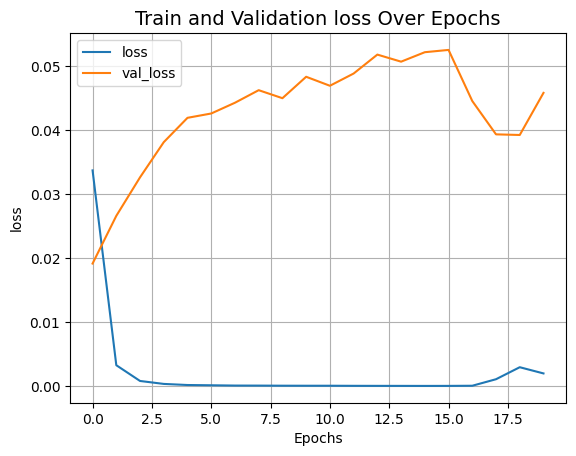

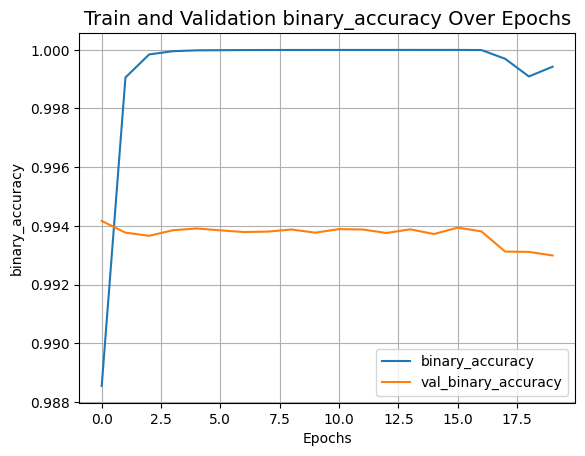

In [23]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [24]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

15/15 [==============================] - 1s 55ms/step - loss: 0.0457 - binary_accuracy: 0.9930
Categorical accuracy on the test set: 99.3%.


In [25]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

4/4 [==============================] - 0s 8ms/step
Abstract: b'When creating digital art, coloring and shading are often time consuming\ntasks that follow the same general patterns. A solution to automatically\ncolorize raw line art would have many practical applications. We propose a\nsetup utilizing two networks in tandem: a color prediction network based only\non outlines, and a shading network conditioned on both outlines and a color\nscheme. We present processing methods to limit information passed in the color\nscheme, improving generalization. Finally, we demonstrate natural-looking\nresults when colorizing outlines from scratch, as well as from a messy,\nuser-defined color scheme.'
Label(s): ['cs.CV']
Predicted Label(s): (cs.CV, stat.ML, cs.LG)
 
Abstract: b'Fingerprint classification is an effective technique for reducing the\ncandidate numbers of fingerprints in the stage of matching in automatic\nfingerprint identification system (AFIS). In recent years, deep learning is an\